In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('../../../optimal-signal-demixing/')
from osd import Problem
from osd.components import (
    MeanSquareSmall, 
    TimeSmoothEntryClose, 
    LinearTrend
)
from osd.components.wrappers import make_columns_equal

In [3]:
T = 100
p = 5

lambda1 = 100
lambda2 = 10
weight = 1
rho = 1 
vavg = None
period = None
np.random.seed(42)
v_in = np.random.randn(T, p)
tsec = TimeSmoothEntryClose(lambda1=lambda1, lambda2=lambda2, vavg=vavg)
v_out = tsec.prox_op(v_in, weight, rho)

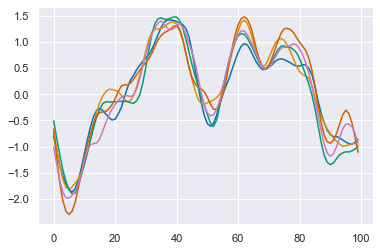

In [4]:
plt.plot(10 * v_out)

In [20]:
np.savetxt('vector_smooth_low_var.txt', 10 * v_out)

In [5]:
X1 = 0.15 * np.random.randn(T, p)
X2 = 10 * v_out
X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
X_real = np.array([X1, X2, X3])
y = np.sum(X_real, axis=0)

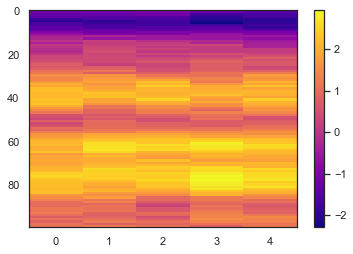

In [6]:
with sns.axes_style('white'):
    plt.imshow(y, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.show()

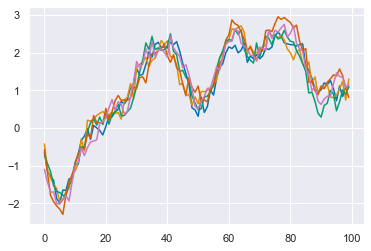

In [7]:
plt.plot(y)

In [40]:
def make_data():
    data_file_path = "vector_smooth_low_var.txt"
    with open(data_file_path) as file:
        data = np.loadtxt(file)
    T, p = data.shape
    np.random.seed(110100100)
    X1 = 0.15 * np.random.randn(T, p)
    X2 = data
    X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
    X_real = np.array([X1, X2, X3])
    y = np.sum(X_real, axis=0)
    return y, X_real

In [41]:
import cvxpy as cvx
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

In [42]:
y, X_real = make_data()
components = [
    MeanSquareSmall(size=y.size),
    TimeSmoothEntryClose(
        lambda1=1e3, lambda2=1e-2, weight=5e-3/y.size
    ),
    make_columns_equal(LinearTrend),
]
problem = Problem(y, components=components)

In [43]:
problem.decompose(how='cvx', reset=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 27 10:06:24 AM: Your problem has 1600 variables, 3 constraints, and 3 parameters.
(CVXPY) Jan 27 10:06:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 10:06:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 27 10:06:24 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 27 10:06:24 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 27 10:06:24 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 27 10:06:24 AM: Applying reduction Qp2SymbolicQ

In [45]:
problem.objective_value

0.028309135871471484

In [46]:
rms(problem.estimates[0] - X_real[0])

0.076906439768064

In [47]:
rms(problem.estimates[1] - X_real[1])

0.22732339432867105

In [48]:
rms(problem.estimates[2] - X_real[2])

0.2236577269477826

In [49]:
problem.decompose(how='admm', reset=True, stop_early=False)

[====================] ...83 iterations, 0.39 sec -- obj_val: 2.83e-02, r: 2.45e-06, tol: 1.01e-05      



In [50]:
problem.objective_value

0.028309136368085783

In [51]:
rms(problem.estimates[0] - X_real[0])

0.07690414867912206

In [52]:
rms(problem.estimates[1] - X_real[1])

0.5093887305752547

In [53]:
rms(problem.estimates[2] - X_real[2])

0.49896396676334276

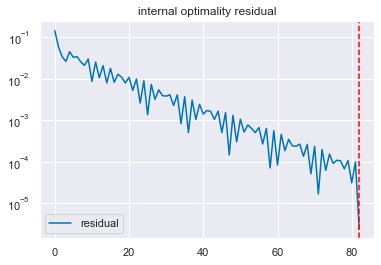

In [54]:
plt.figure()
plt.plot(problem.admm_result['optimality_residual'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

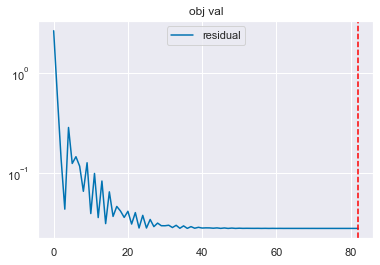

In [55]:
plt.figure()
plt.plot(problem.admm_result['obj_vals'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.legend()
plt.title('obj val')
plt.yscale('log')
plt.show()

In [56]:
problem.decompose(how='bcd', reset=True)

Starting BCD...
y shape: (100, 5)
X shape: (3, 100, 5)

[====================] ...2 iterations, 0.01 sec -- obj_val: 2.83e-02, r: 2.05e-16, tol: 1.01e-05      



In [59]:
problem.objective_value

0.02830913587087043

In [60]:
rms(problem.estimates[0] - X_real[0])

0.07690643694411026

In [61]:
rms(problem.estimates[1] - X_real[1])

1.166034199442614

In [62]:
rms(problem.estimates[2] - X_real[2])

1.1576127763925748

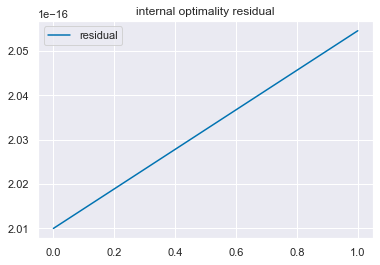

In [57]:
plt.figure()
plt.plot(problem.bcd_result['optimality_residual'], label='residual')
plt.legend()
plt.title('internal optimality residual')
plt.show()

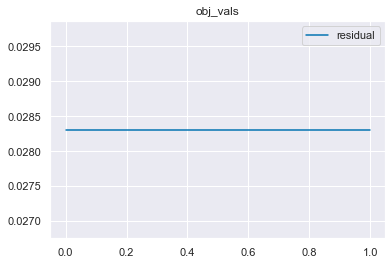

In [58]:
plt.figure()
plt.plot(problem.bcd_result['obj_vals'], label='residual')
plt.legend()
plt.title('obj_vals')
plt.show()

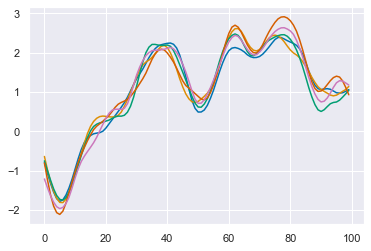

In [18]:
plt.plot(problem.estimates[1])

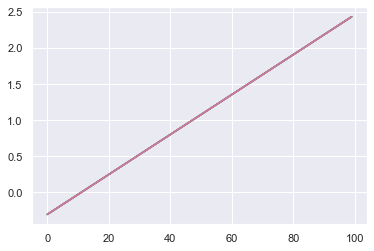

In [77]:
plt.plot(problem.estimates[2])

In [78]:
from osd.utilities import make_estimate